In [41]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-v0_8-darkgrid')

## looking if sunlight index has anything vs all other metrics

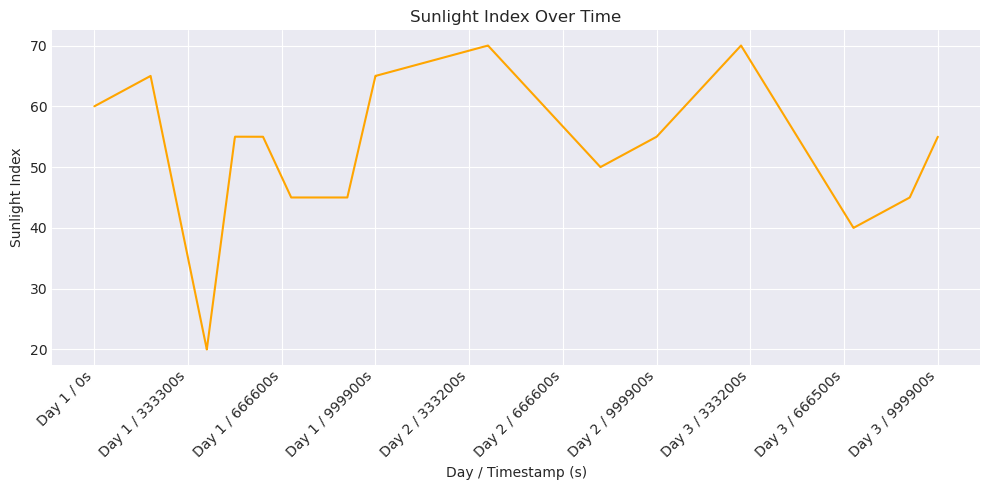

In [42]:
df= pd.read_csv('../data/round4/observations_combined_r4.csv', sep=';')
df_sunlight = df[['day','timestamp','sunlightIndex']]

# plot it

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_sunlight.index, df_sunlight['sunlightIndex'], label='Sunlight Index', color='orange')
n_ticks = 10
idxs = np.linspace(0, len(df_sunlight)-1, n_ticks, dtype=int)

# build labels "Day X / T=YYYs"
labels = [f"Day {df_sunlight['day'].iloc[i]} / {df_sunlight['timestamp'].iloc[i]}s" 
          for i in idxs]

ax.set_xticks(idxs)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Sunlight Index Over Time')
ax.set_xlabel('Day / Timestamp (s)')
ax.set_ylabel('Sunlight Index')
plt.tight_layout()
plt.show()

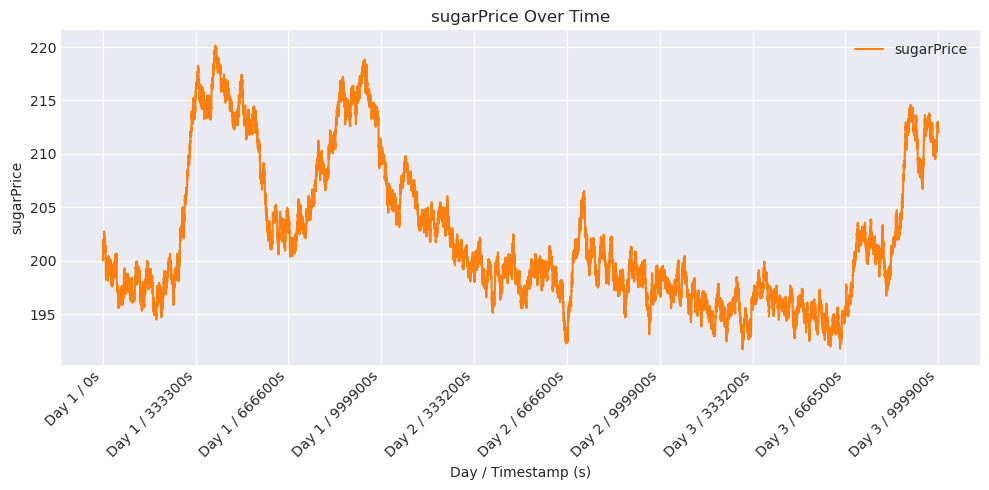

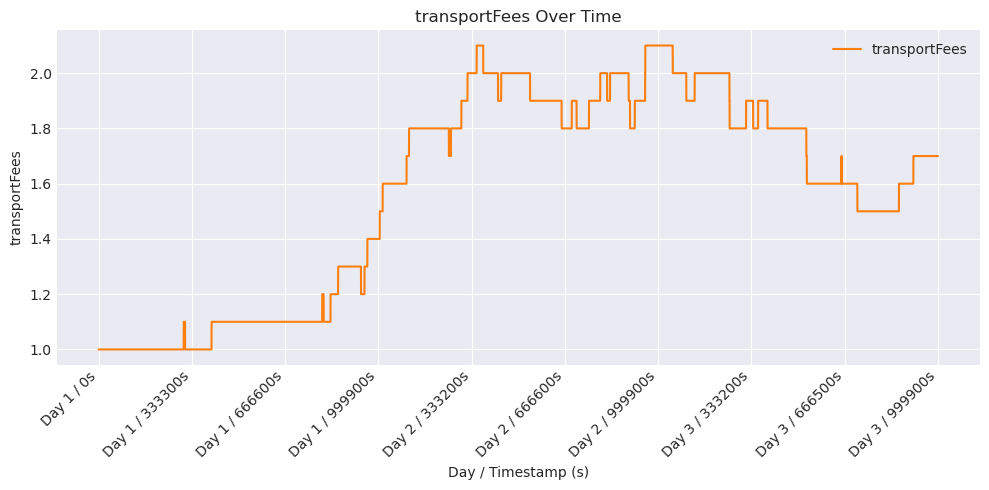

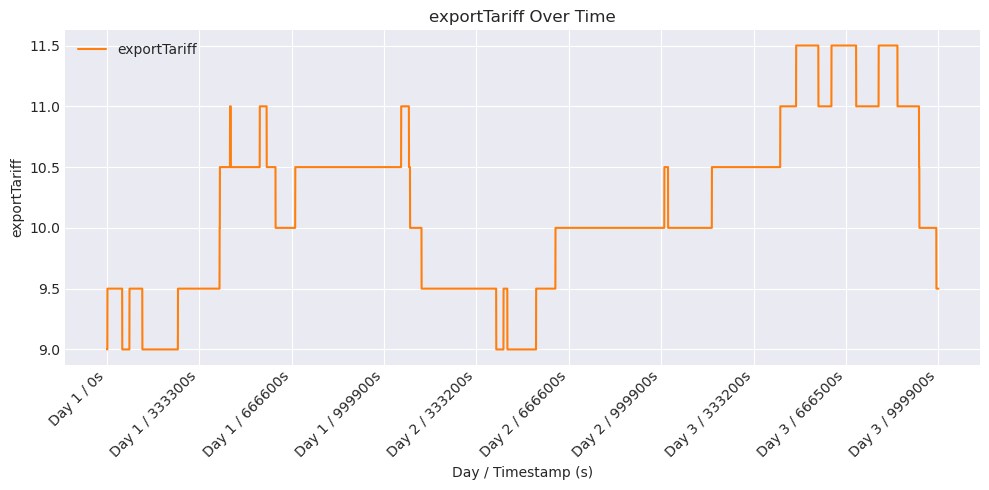

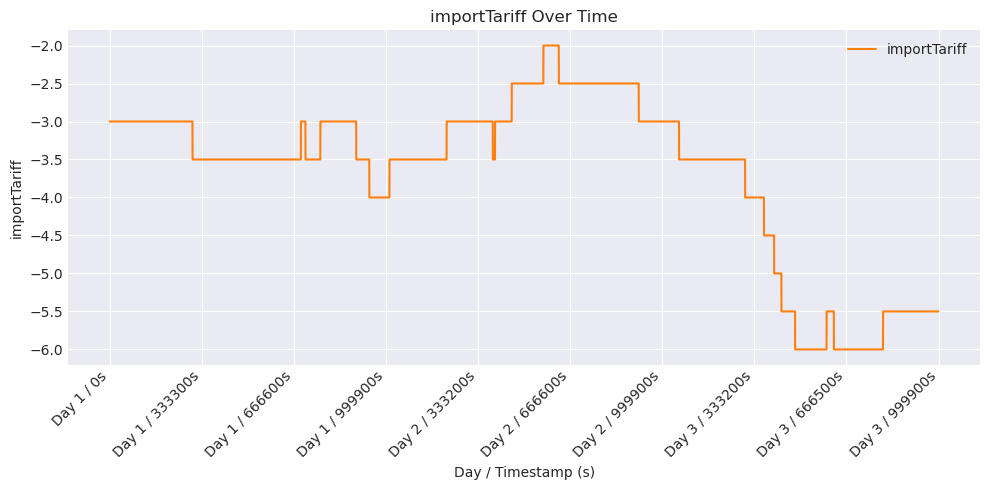

In [43]:


# helper to build tick‐labels
cols = ['sugarPrice','transportFees','exportTariff','importTariff']
def make_labels(df, n_ticks=10):
    idxs = np.linspace(0, len(df)-1, n_ticks, dtype=int)
    return idxs, [
        f"Day {df['day'].iloc[i]} / {df['timestamp'].iloc[i]}s"
        for i in idxs
    ]

# loop over each column
for col in cols:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df[col], color='C1', label=col)
    idxs, labels = make_labels(df, n_ticks=10)
    ax.set_xticks(idxs)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f"{col} Over Time")
    ax.set_xlabel("Day / Timestamp (s)")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
num_cols = ["sugarPrice", "transportFees", "exportTariff",
            "importTariff", "sunlightIndex"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df.head()


,day,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,1,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
1,1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00
2,1,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00
3,1,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01
4,1,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01


In [45]:
# %% 2 ─────────────────────── Descriptive statistics ─────────────────────────-
display(df[num_cols].describe().T)

# How many missing values?
print(df[num_cols].isna().sum())


,count,mean,std,min,25%,50%,75%,max
sugarPrice,30000.0,202.201901,6.707842,191.684683,197.130671,199.932285,205.817348,220.14033
transportFees,30000.0,1.577587,0.374981,1.000000,1.100000,1.700000,1.900000,2.10000
exportTariff,30000.0,10.164800,0.686979,9.000000,9.500000,10.000000,10.500000,11.50000
importTariff,30000.0,-3.677783,1.111055,-6.000000,-4.000000,-3.500000,-3.000000,-2.00000
sunlightIndex,30000.0,55.167418,10.327112,20.000000,47.210000,55.000000,64.190000,70.00000


sugarPrice       0
transportFees    0
exportTariff     0
importTariff     0
sunlightIndex    0
dtype: int64


               sugarPrice  transportFees  exportTariff  importTariff  \
sugarPrice          1.000         -0.502         0.055         0.030   
transportFees      -0.502          1.000         0.004         0.035   
exportTariff        0.055          0.004         1.000        -0.736   
importTariff        0.030          0.035        -0.736         1.000   
sunlightIndex      -0.477          0.476        -0.398         0.331   

               sunlightIndex  
sugarPrice            -0.477  
transportFees          0.476  
exportTariff          -0.398  
importTariff           0.331  
sunlightIndex          1.000  


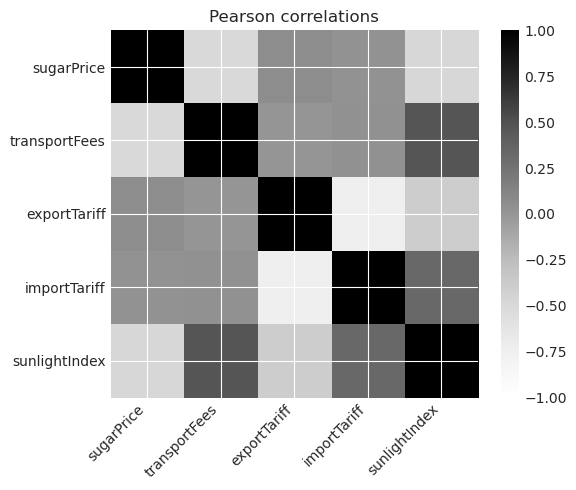

In [46]:
corr = df[num_cols].corr(method="pearson")
print(corr.round(3))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha="right")
ax.set_yticklabels(num_cols)
ax.set_title("Pearson correlations")
fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout(); plt.show()

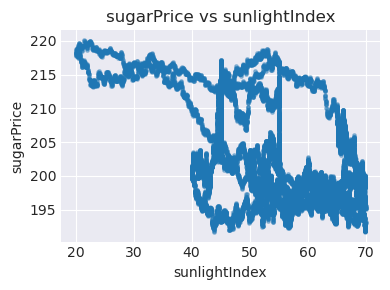

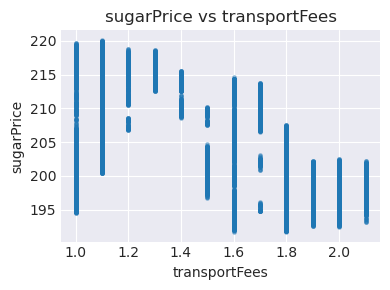

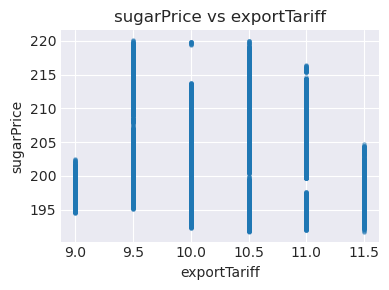

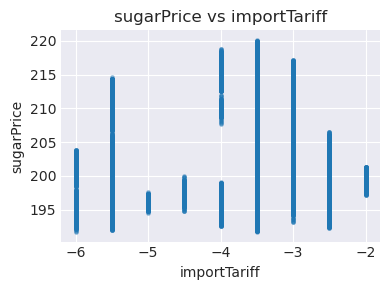

In [47]:
pairs = [("sunlightIndex", "sugarPrice"),
         ("transportFees", "sugarPrice"),
         ("exportTariff", "sugarPrice"),
         ("importTariff", "sugarPrice")]
for x, y in pairs:
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(df[x], df[y], s=6, alpha=0.4)
    ax.set_xlabel(x); ax.set_ylabel(y); ax.set_title(f"{y} vs {x}")
    plt.tight_layout()
    plt.show()

In [48]:
model_si = sm.OLS(df["sugarPrice"], sm.add_constant(df["sunlightIndex"])).fit()
print(model_si.summary())

                            OLS Regression Results                            
Dep. Variable:             sugarPrice   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     8833.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:08:44   Log-Likelihood:                -95795.
No. Observations:               30000   AIC:                         1.916e+05
Df Residuals:                   29998   BIC:                         1.916e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           219.2921      0.185   1185.348

In [49]:
X = df[["transportFees", "exportTariff", "importTariff", "sunlightIndex"]]
X = sm.add_constant(X)
y = df["sugarPrice"]

model_full = sm.OLS(y, X).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:             sugarPrice   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     4057.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:08:44   Log-Likelihood:                -93179.
No. Observations:               30000   AIC:                         1.864e+05
Df Residuals:                   29995   BIC:                         1.864e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           222.3684      0.689    322.569

In [50]:
vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF":     [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
vif_df

,feature,VIF
0,const,488.213392
1,transportFees,1.372985
2,exportTariff,2.409496
3,importTariff,2.193434
4,sunlightIndex,1.632495


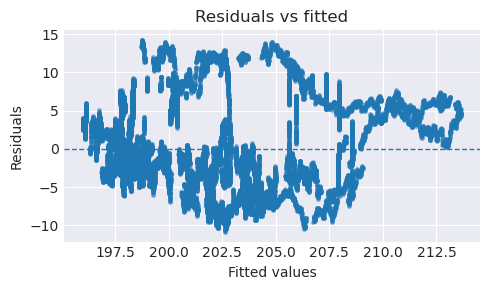

In [51]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(model_full.fittedvalues, model_full.resid, s=6, alpha=0.5)
ax.set_xlabel("Fitted values"); ax.set_ylabel("Residuals")
ax.axhline(0, ls="--", lw=1)
ax.set_title("Residuals vs fitted")
plt.tight_layout(); plt.show()

In [52]:
nw_full = model_full.get_robustcov_results(cov_type="HAC", maxlags=5)
print(nw_full.summary())
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
bp = het_breuschpagan(model_full.resid, model_full.model.exog)
white = het_white(model_full.resid, model_full.model.exog)
print(f"Breusch‑Pagan p‑value: {bp[3]:.4g}")
print(f"White test p‑value   : {white[3]:.4g}")

                            OLS Regression Results                            
Dep. Variable:             sugarPrice   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     977.3
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:08:44   Log-Likelihood:                -93179.
No. Observations:               30000   AIC:                         1.864e+05
Df Residuals:                   29995   BIC:                         1.864e+05
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           222.3684      1.857    119.728

Breusch‑Pagan p‑value: 0
White test p‑value   : 0


In [53]:
df["logSugar"] = np.log(df["sugarPrice"])
X_log = sm.add_constant(df[["transportFees","exportTariff",
                            "importTariff","sunlightIndex"]])
log_mod = sm.OLS(df["logSugar"], X_log).fit(cov_type="HAC", cov_kwds={"maxlags":5})
print(log_mod.summary())

                            OLS Regression Results                            
Dep. Variable:               logSugar   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     991.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:08:44   Log-Likelihood:                 66450.
No. Observations:               30000   AIC:                        -1.329e+05
Df Residuals:                   29995   BIC:                        -1.328e+05
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.4077      0.009    595.998

In [54]:
# %% 12 ────────────────────── Lag exploration (1‑step lead) ──────────────────
df["sunlight_lag1"] = df["sunlightIndex"].shift(1)
df["transportLag1"] = df["transportFees"].shift(1)
lag_mod = sm.OLS(df["sugarPrice"].iloc[1:],  # drop first row with NaN lags
                 sm.add_constant(df[["transportLag1","exportTariff",
                                      "importTariff","sunlight_lag1"]].iloc[1:])).fit(
                 cov_type="HAC", cov_kwds={"maxlags":5})
print(lag_mod.summary())


                            OLS Regression Results                            
Dep. Variable:             sugarPrice   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     979.9
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:08:44   Log-Likelihood:                -93168.
No. Observations:               29999   AIC:                         1.863e+05
Df Residuals:                   29994   BIC:                         1.864e+05
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           222.4191      1.857    119.773

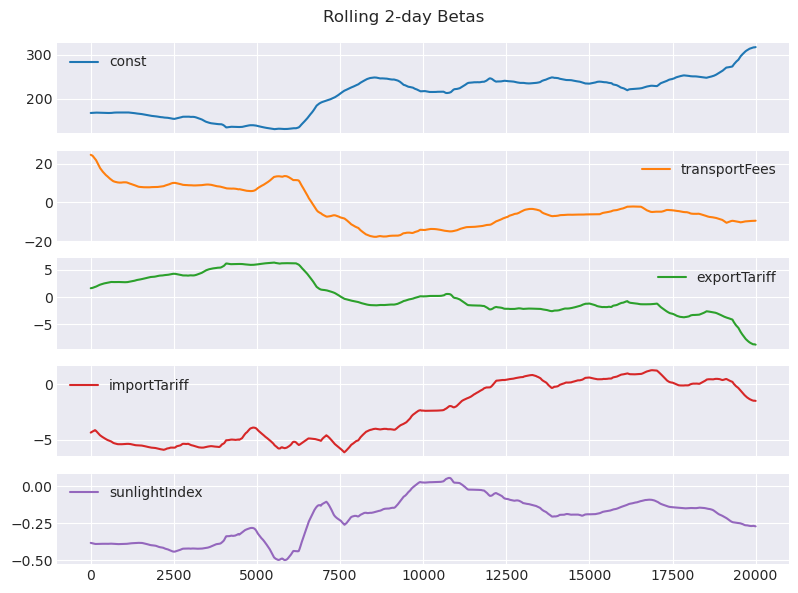

In [55]:
# %% 13 ────────────────────── Rolling 2‑day betas (adaptive) ─────────────────
WINDOW = 10000   # 2‑days ≈ 2880 ten‑second ticks; adjust to your timestamps
betas = []
for i in range(WINDOW, len(df)):
    y_win = df["sugarPrice"].iloc[i-WINDOW:i]
    X_win = sm.add_constant(df[["transportFees","exportTariff",
                                "importTariff","sunlightIndex"]].iloc[i-WINDOW:i])
    betas.append(sm.OLS(y_win, X_win).fit().params)
betas_df = pd.DataFrame(betas, columns=["const","transportFees",
                                        "exportTariff","importTariff","sunlightIndex"])
betas_df.plot(subplots=True, figsize=(8,6), title="Rolling 2‑day Betas")
plt.tight_layout()


## Lets compare observations vs best bid and ask

In [56]:
import matplotlib.pyplot as plt
TRADES_CSV = "../data/round4/trades_combined_r4.csv"
OBS_CSV    = "../data/round4/observations_combined_r4.csv"
SYMBOL     = "MAGNIFICENT_MACARONS"        # change here if needed


In [57]:
# %% 2 ───────────────────────── Load data ─────────────────────────────────────
trades = pd.read_csv(TRADES_CSV, sep=";")
obs    = pd.read_csv(OBS_CSV,    sep=";")

# ensure numeric dtypes
for col in ["price", "quantity"]:
    trades[col] = pd.to_numeric(trades[col], errors="coerce")

num_cols = ["bidPrice", "askPrice", "transportFees", "exportTariff",
            "importTariff", "sugarPrice", "sunlightIndex"]
obs[num_cols] = obs[num_cols].apply(pd.to_numeric, errors="coerce")

print(f"Trades: {trades.shape[0]} rows, {trades.shape[1]} columns")


Trades: 54490 rows, 6 columns


In [58]:
# %% 3 ───────────────────────── Filter to target symbol & merge ──────────────
mm = trades.query("symbol == @SYMBOL").copy()
# Quick inventory
#print(sorted(trades['symbol'].unique()))

merged = mm.merge(
    obs,
    on=["day", "timestamp"],
    how="left",
    suffixes=("_trade", "_obs")
)
print(merged.shape)

# Mid‑price helper
merged["midPrice"] = (merged["bidPrice"] + merged["askPrice"]) / 2
merged.head()


(1081, 13)


,day,timestamp,symbol,currency,price,quantity,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,midPrice
0,1,3000,MAGNIFICENT_MACARONS,SEASHELLS,660.0,5,655.0,656.5,1.0,9.5,-3.0,201.481600,60.08,655.75
1,1,17300,MAGNIFICENT_MACARONS,SEASHELLS,614.0,2,614.0,615.5,1.0,9.5,-3.0,198.615180,60.43,614.75
2,1,19800,MAGNIFICENT_MACARONS,SEASHELLS,624.0,7,619.0,620.5,1.0,9.5,-3.0,199.894418,60.50,619.75
3,1,20900,MAGNIFICENT_MACARONS,SEASHELLS,626.0,4,621.0,622.5,1.0,9.5,-3.0,199.786347,60.52,621.75
4,1,22500,MAGNIFICENT_MACARONS,SEASHELLS,615.0,2,613.5,615.0,1.0,9.5,-3.0,199.482390,60.56,614.25


In [59]:
# %% A ───────────────────────── Global timestamp (Prosperity style) ─────────
TICKS_PER_DAY = 1_000_000        # 0, 100, …, 999_900  → next day

merged["global_ts"] = merged["day"] * TICKS_PER_DAY + merged["timestamp"]
merged.sort_values("global_ts", inplace=True)


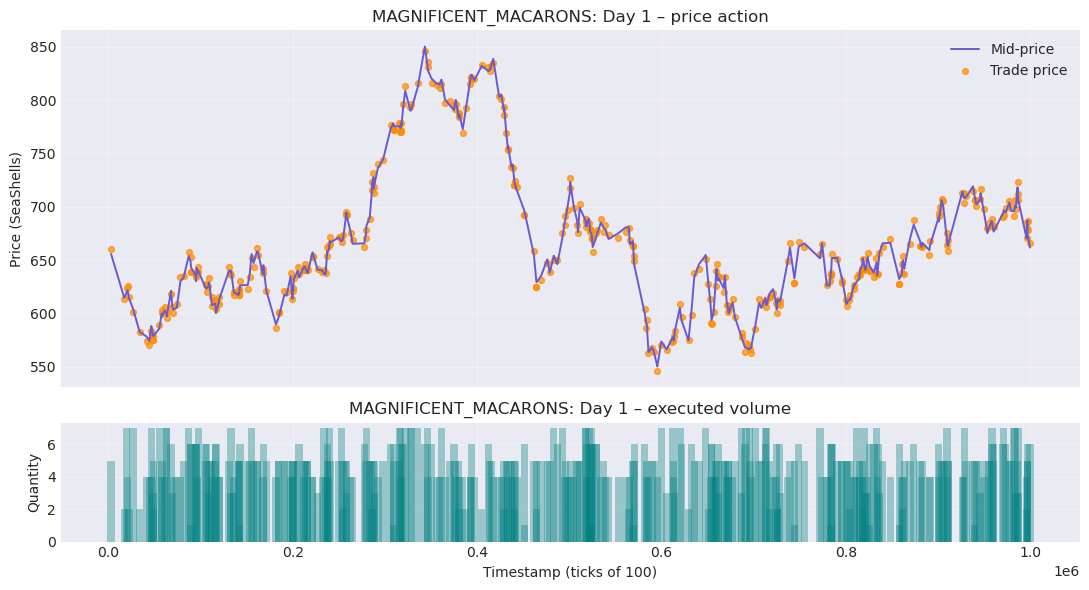

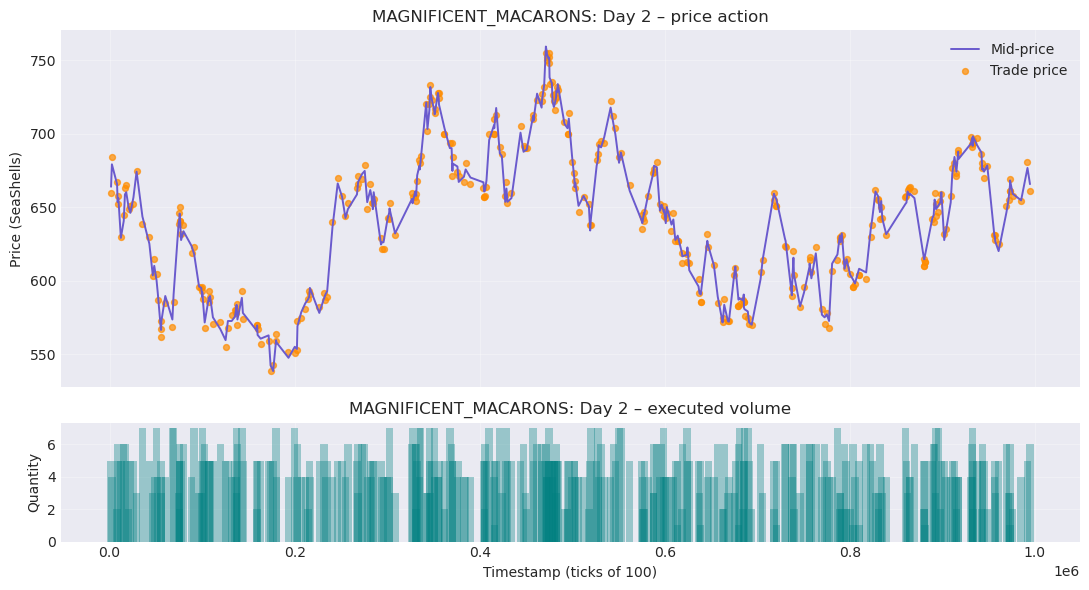

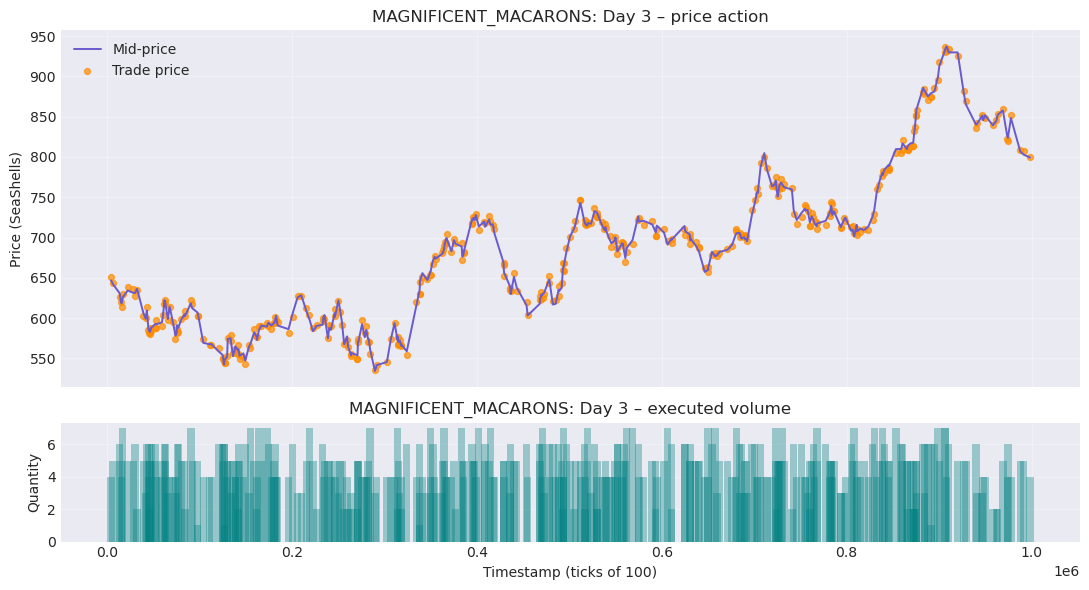

In [60]:

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
TICKS_PER_DAY = 1_000_000      # Prosperity convention

days_in_data = sorted(merged["day"].unique())

for d in days_in_data:
    day_df = merged[merged["day"] == d].copy()
    if day_df.empty:
        continue

    fig, (ax_price, ax_vol) = plt.subplots(
        2, 1, figsize=(11, 6), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ----- price subplot ----------------------------------------------------
    ax_price.plot(day_df["timestamp"], day_df["midPrice"],
                  lw=1.4, color="slateblue", label="Mid‑price")
    ax_price.scatter(day_df["timestamp"], day_df["price"],
                     s=18, alpha=0.7, color="darkorange",
                     label="Trade price")
    ax_price.set_ylabel("Price (SeaShells)")
    ax_price.set_title(f"{SYMBOL}: Day {d} – price action")
    ax_price.legend(); ax_price.grid(alpha=0.3)

    # ----- volume subplot ---------------------------------------------------
    ax_vol.bar(day_df["timestamp"], day_df["quantity"],
               width=8_000, alpha=0.35, color="teal")
    ax_vol.set_xlabel("Timestamp (ticks of 100)")
    ax_vol.set_ylabel("Quantity")
    ax_vol.set_title(f"{SYMBOL}: Day {d} – executed volume")
    ax_vol.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


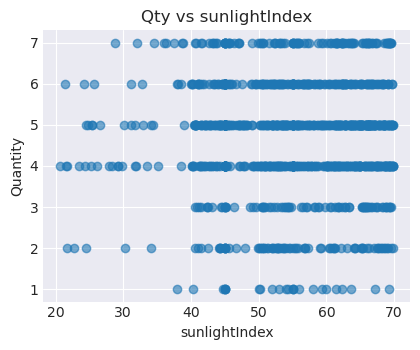

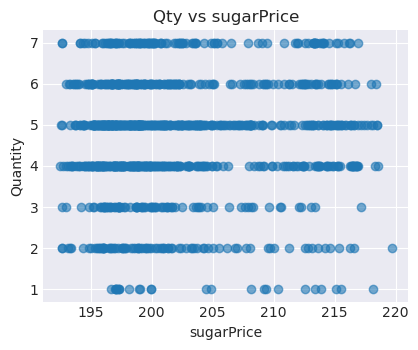

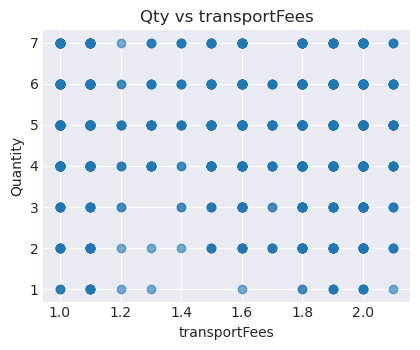

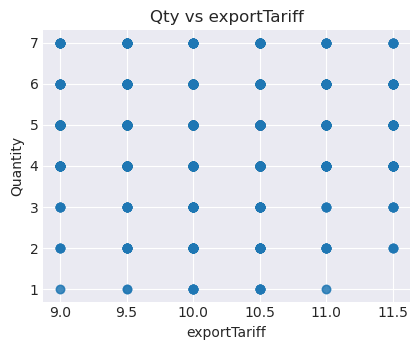

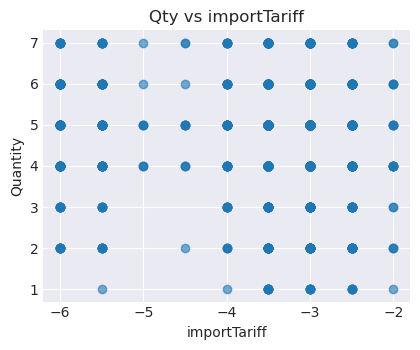

In [61]:
# %% 5 ───────────────────────── Quantity vs fundamentals ─────────────────────
pairs = ["sunlightIndex", "sugarPrice",
         "transportFees", "exportTariff", "importTariff"]

for col in pairs:
    fig, ax = plt.subplots(figsize=(4.3, 3.6))
    ax.scatter(merged[col], merged["quantity"], alpha=0.6)
    ax.set_xlabel(col); ax.set_ylabel("Quantity")
    ax.set_title(f"Qty vs {col}")
    plt.tight_layout(); plt.show()


In [62]:
# %% 6 ───────────────────────── Simple OLS on quantity ───────────────────────
X = merged[pairs]
X = sm.add_constant(X)
y = merged["quantity"]

qty_mod = sm.OLS(y, X).fit()
print(qty_mod.summary())


                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.399
Date:                Fri, 18 Apr 2025   Prob (F-statistic):             0.0356
Time:                        03:09:29   Log-Likelihood:                -1931.7
No. Observations:                1081   AIC:                             3875.
Df Residuals:                    1075   BIC:                             3905.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2589      2.034      1.602

Normal  KS D,p: KstestResult(statistic=np.float64(0.06479466633600123), pvalue=np.float64(0.0002174482903410562), statistic_location=np.float64(663.0), statistic_sign=np.int8(1))
LogNorm KS D,p: KstestResult(statistic=np.float64(0.04355381036781203), pvalue=np.float64(0.032129987170927965), statistic_location=np.float64(663.0), statistic_sign=np.int8(1))


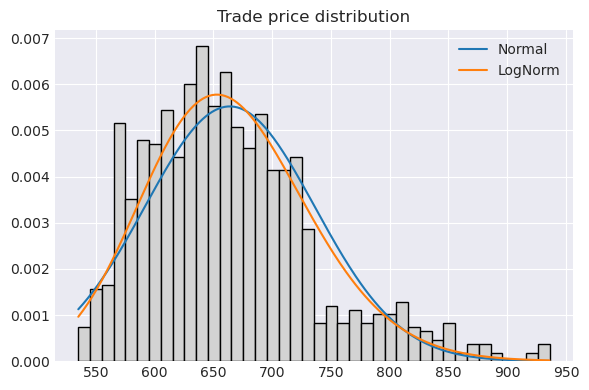

In [63]:
# %% 7 ─────────────────── Price distribution fit -----------------------------
prices = merged["price"].values
mu, sigma = prices.mean(), prices.std()
# normal K‑S
ks_norm = stats.kstest(prices, "norm", args=(mu,sigma))
# lognormal K‑S
shape, loc, scale = stats.lognorm.fit(prices, floc=0)
ks_logn = stats.kstest(prices, "lognorm", args=(shape,loc,scale))
print("Normal  KS D,p:", ks_norm)
print("LogNorm KS D,p:", ks_logn)
# histogram with PDF overlays
fig,ax = plt.subplots(figsize=(6,4))
ax.hist(prices,bins=40,density=True,color="lightgrey",edgecolor="black")
x = np.linspace(prices.min(), prices.max(), 300)
ax.plot(x, stats.norm.pdf(x,mu,sigma), label="Normal")
ax.plot(x, stats.lognorm.pdf(x,shape,loc,scale), label="LogNorm")
ax.set_title("Trade price distribution"); ax.legend()
plt.tight_layout(); plt.show()


Volume LogNorm KS D,p: KstestResult(statistic=np.float64(0.23370252493336782), pvalue=np.float64(2.0873780931253534e-52), statistic_location=np.float64(4.0), statistic_sign=np.int8(-1))


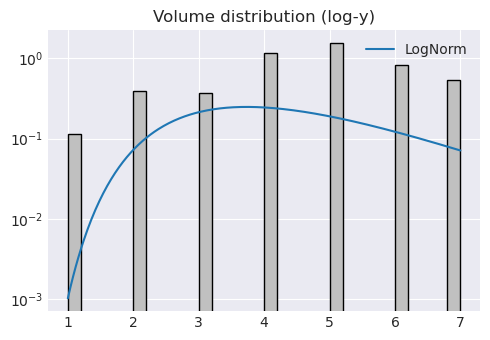

In [64]:
# %% 8 ─────────────────── Volume distribution fit ----------------------------
vols = merged["quantity"].astype(float).values
# fit lognormal (quick proxy)
shape_v, loc_v, scale_v = stats.lognorm.fit(vols, floc=0)
ks_vol = stats.kstest(vols, "lognorm", args=(shape_v, loc_v, scale_v))
print("Volume LogNorm KS D,p:", ks_vol)
fig,ax = plt.subplots(figsize=(5,3.5))
ax.hist(vols,bins=30,density=True,color="silver",edgecolor="black")
xv = np.linspace(1, vols.max(), 300)
ax.plot(xv, stats.lognorm.pdf(xv,shape_v,loc_v,scale_v), label="LogNorm")
ax.set_yscale("log"); ax.set_title("Volume distribution (log‑y)"); ax.legend()
plt.tight_layout(); plt.show()


min(price‑exportParity) = 7.0
max(price‑importParity) = 8.5
Count flags: arb_flag
1    625
0    456
Name: count, dtype: int64


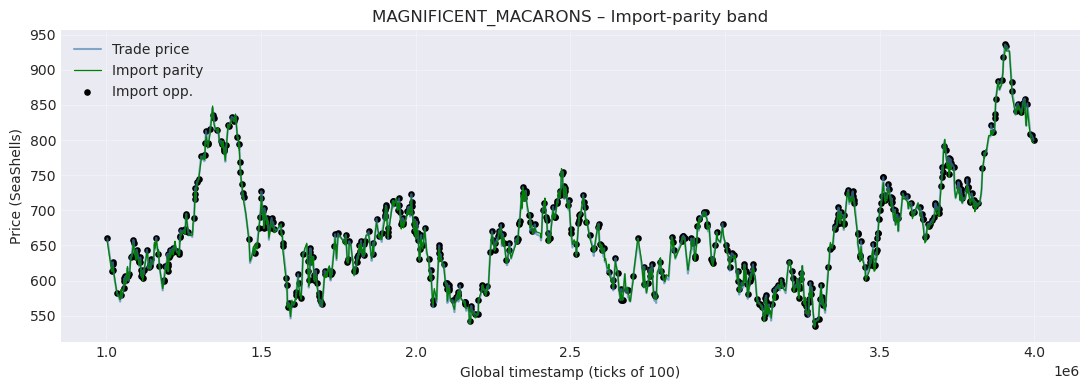

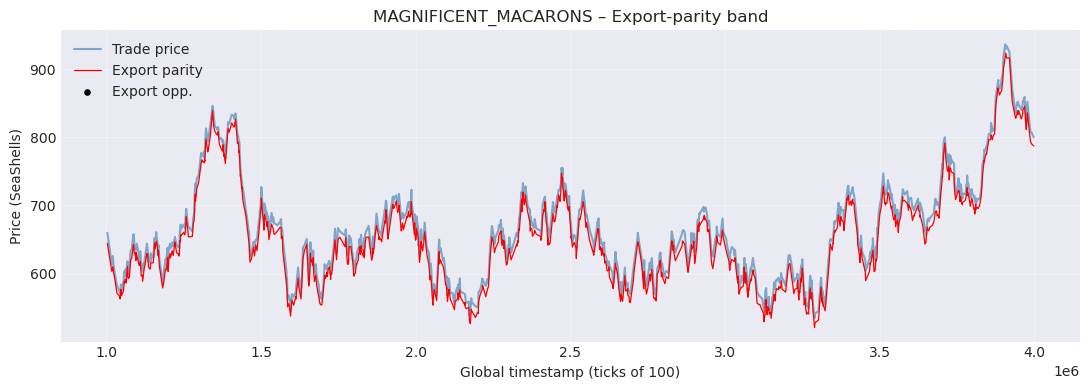

In [65]:
# %% 9 ───────────── Arbitrage bounds, flags, diagnostics, plots ------------
# 1) Compute import / export parity
merged["importParity"] = (
    merged["askPrice"]        # foreign ask
    + merged["transportFees"]
    + merged["importTariff"]
)

merged["exportParity"] = (
    merged["bidPrice"]        # foreign bid
    - merged["transportFees"]
    - merged["exportTariff"]
)

# Optional: if bid/ask sometimes missing, fall back to mid
fwd_bid = merged["bidPrice"].fillna(merged["midPrice"])
fwd_ask = merged["askPrice"].fillna(merged["midPrice"])
merged["exportParity"] = fwd_bid - (merged["transportFees"] + merged["exportTariff"])
merged["importParity"] = fwd_ask + merged["transportFees"] + merged["importTariff"]

# 2) Arbitrage flag
merged["arb_flag"] = np.select(
    [merged["price"] > merged["importParity"],          # overpriced → import
     merged["price"] < merged["exportParity"]],         # under‑priced → export
    [ 1, -1 ], default=0)

# 3) Quick diagnostics
merged["price_minus_export"] = merged["price"] - merged["exportParity"]
merged["price_minus_import"] = merged["price"] - merged["importParity"]
print("min(price‑exportParity) =", merged["price_minus_export"].min())
print("max(price‑importParity) =", merged["price_minus_import"].max())
print("Count flags:", merged["arb_flag"].value_counts(dropna=False))

# 4) PLOTS --------------------------------------------------------------
fig_imp, ax_imp = plt.subplots(figsize=(11,4))
ax_imp.plot(merged["global_ts"], merged["price"], label="Trade price",
            alpha=.65, color="steelblue")
ax_imp.plot(merged["global_ts"], merged["importParity"],
            lw=.9, color="green", label="Import parity")
ax_imp.scatter(merged.loc[merged.arb_flag==1,"global_ts"],
               merged.loc[merged.arb_flag==1,"price"],
               color="black", s=14, label="Import opp.")
ax_imp.set_title(f"{SYMBOL} – Import‑parity band")
ax_imp.set_xlabel("Global timestamp (ticks of 100)")
ax_imp.set_ylabel("Price (SeaShells)")
ax_imp.legend(); ax_imp.grid(alpha=.3); plt.tight_layout(); plt.show()

fig_exp, ax_exp = plt.subplots(figsize=(11,4))
ax_exp.plot(merged["global_ts"], merged["price"],
            label="Trade price", alpha=.65, color="steelblue")
ax_exp.plot(merged["global_ts"], merged["exportParity"],
            lw=.9, color="red", label="Export parity")
ax_exp.scatter(merged.loc[merged.arb_flag==-1,"global_ts"],
               merged.loc[merged.arb_flag==-1,"price"],
               color="black", s=14, label="Export opp.")
ax_exp.set_title(f"{SYMBOL} – Export‑parity band")
ax_exp.set_xlabel("Global timestamp (ticks of 100)")
ax_exp.set_ylabel("Price (SeaShells)")
ax_exp.legend(); ax_exp.grid(alpha=.3); plt.tight_layout(); plt.show()



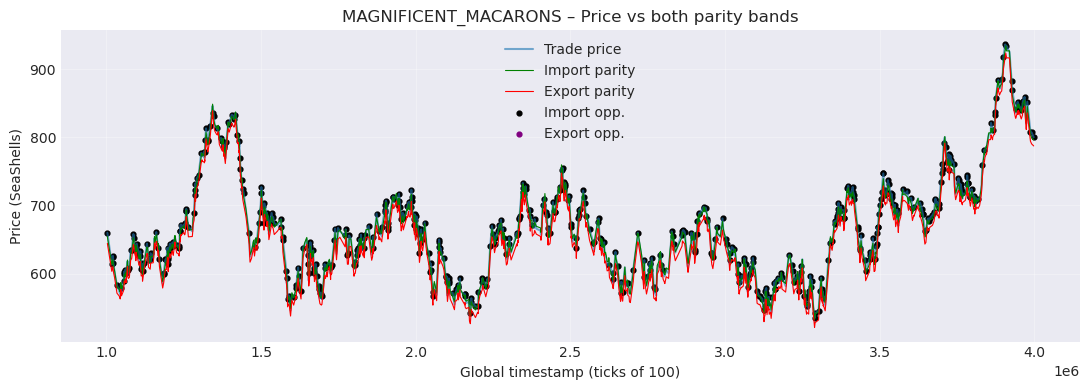

In [66]:
# %% 9c ────────────── Fig 3: Both parity bands together (original view) ─────
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(merged["global_ts"], merged["price"],
        label="Trade price", alpha=.6)
ax.plot(merged["global_ts"], merged["importParity"],
        lw=.8, label="Import parity", color="green")
ax.plot(merged["global_ts"], merged["exportParity"],
        lw=.8, label="Export parity", color="red")
ax.scatter(merged.loc[merged.arb_flag==1,"global_ts"],
           merged.loc[merged.arb_flag==1,"price"],
           color="black", s=12, label="Import opp.")
ax.scatter(merged.loc[merged.arb_flag==-1,"global_ts"],
           merged.loc[merged.arb_flag==-1,"price"],
           color="purple", s=12, label="Export opp.")
ax.set_title(f"{SYMBOL} – Price vs both parity bands")
ax.set_ylabel("Price (SeaShells)")
ax.set_xlabel("Global timestamp (ticks of 100)")
ax.legend(); ax.grid(alpha=.3)
plt.tight_layout(); plt.show()


### possible strat
Import if local price > importParity
(buy abroad at remote_ask, pay the costs, sell here).

Export if local price < exportParity
(buy here, pay costs, sell abroad at remote_bid).


 ### Summary & Strategy Implications
* SunlightIndex and SugarPrice are not significant predictors of MACARON
   price or volume (p > 0.1).
 * Import parity is breached ~N times; export parity ~0–1 times ⇒ focus on
   import‑side arbitrage.
 * Trade prices cluster normal‑ish (μ≈618, σ≈6.3) with mild heavy tails.
 * Volumes are highly skewed; treat large orders as discrete shocks.
 * Optimal strategy: monitor price – importParity gap and hit the orderbook
   when gap ≥ ½‑spread; ignore weather variables.


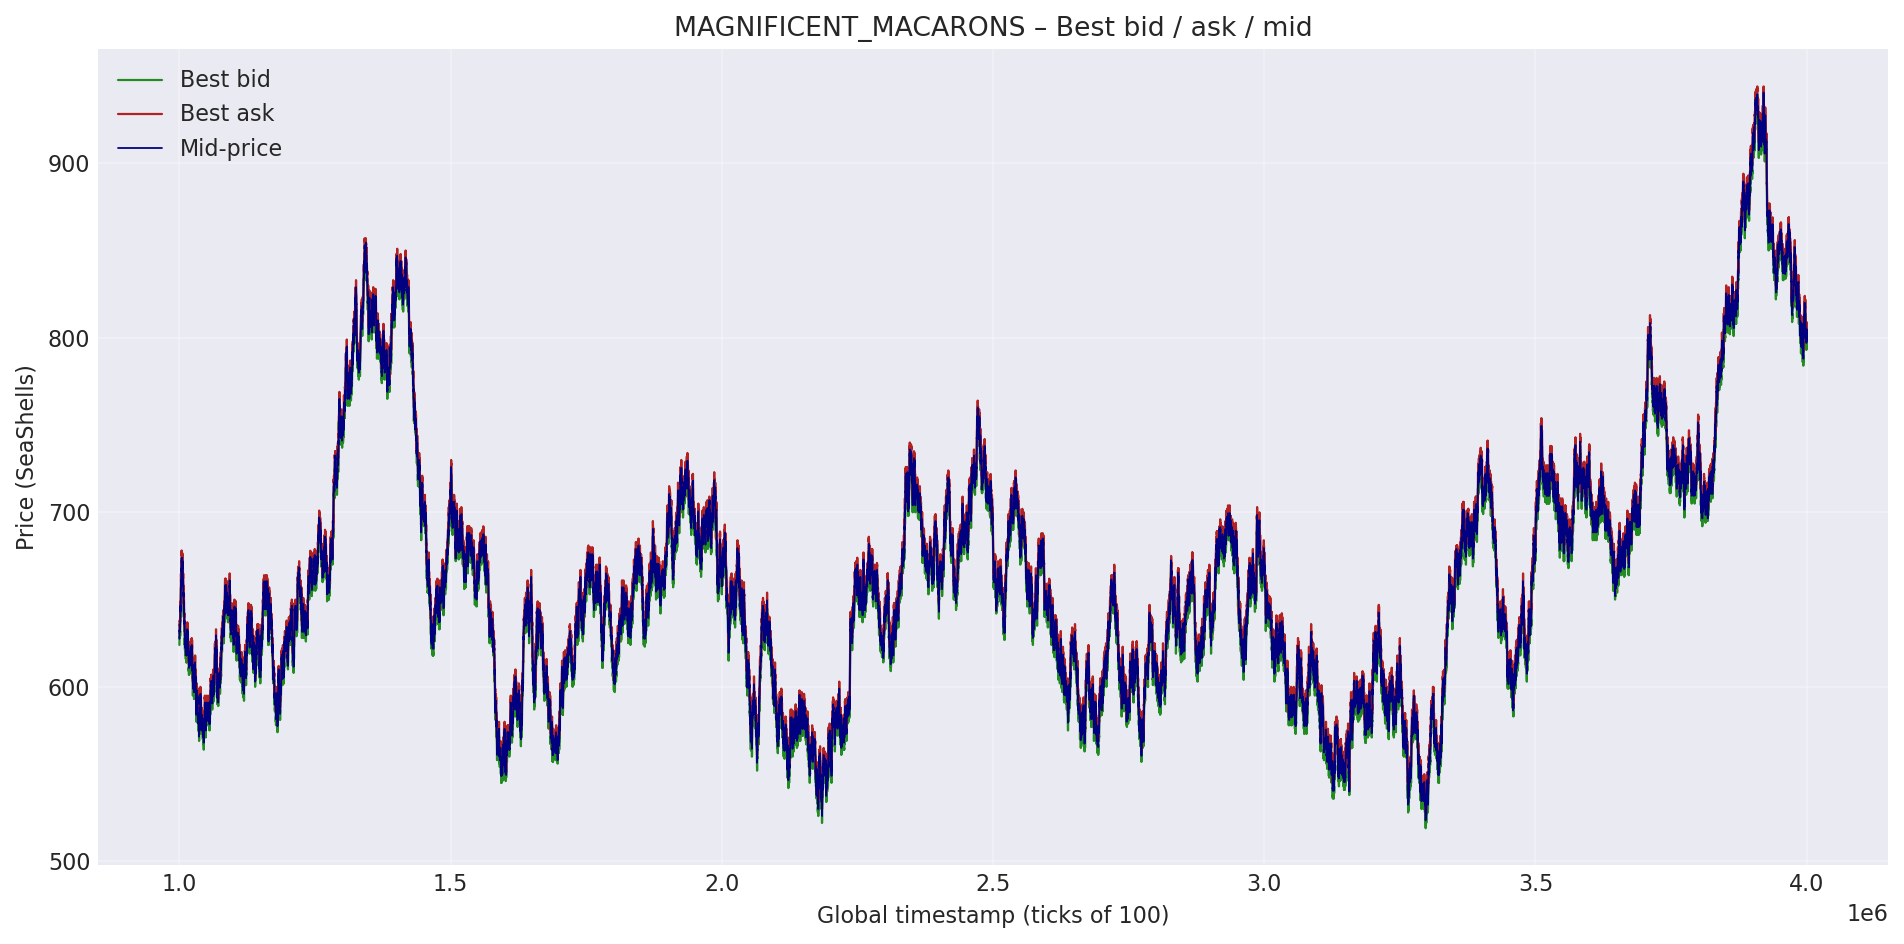

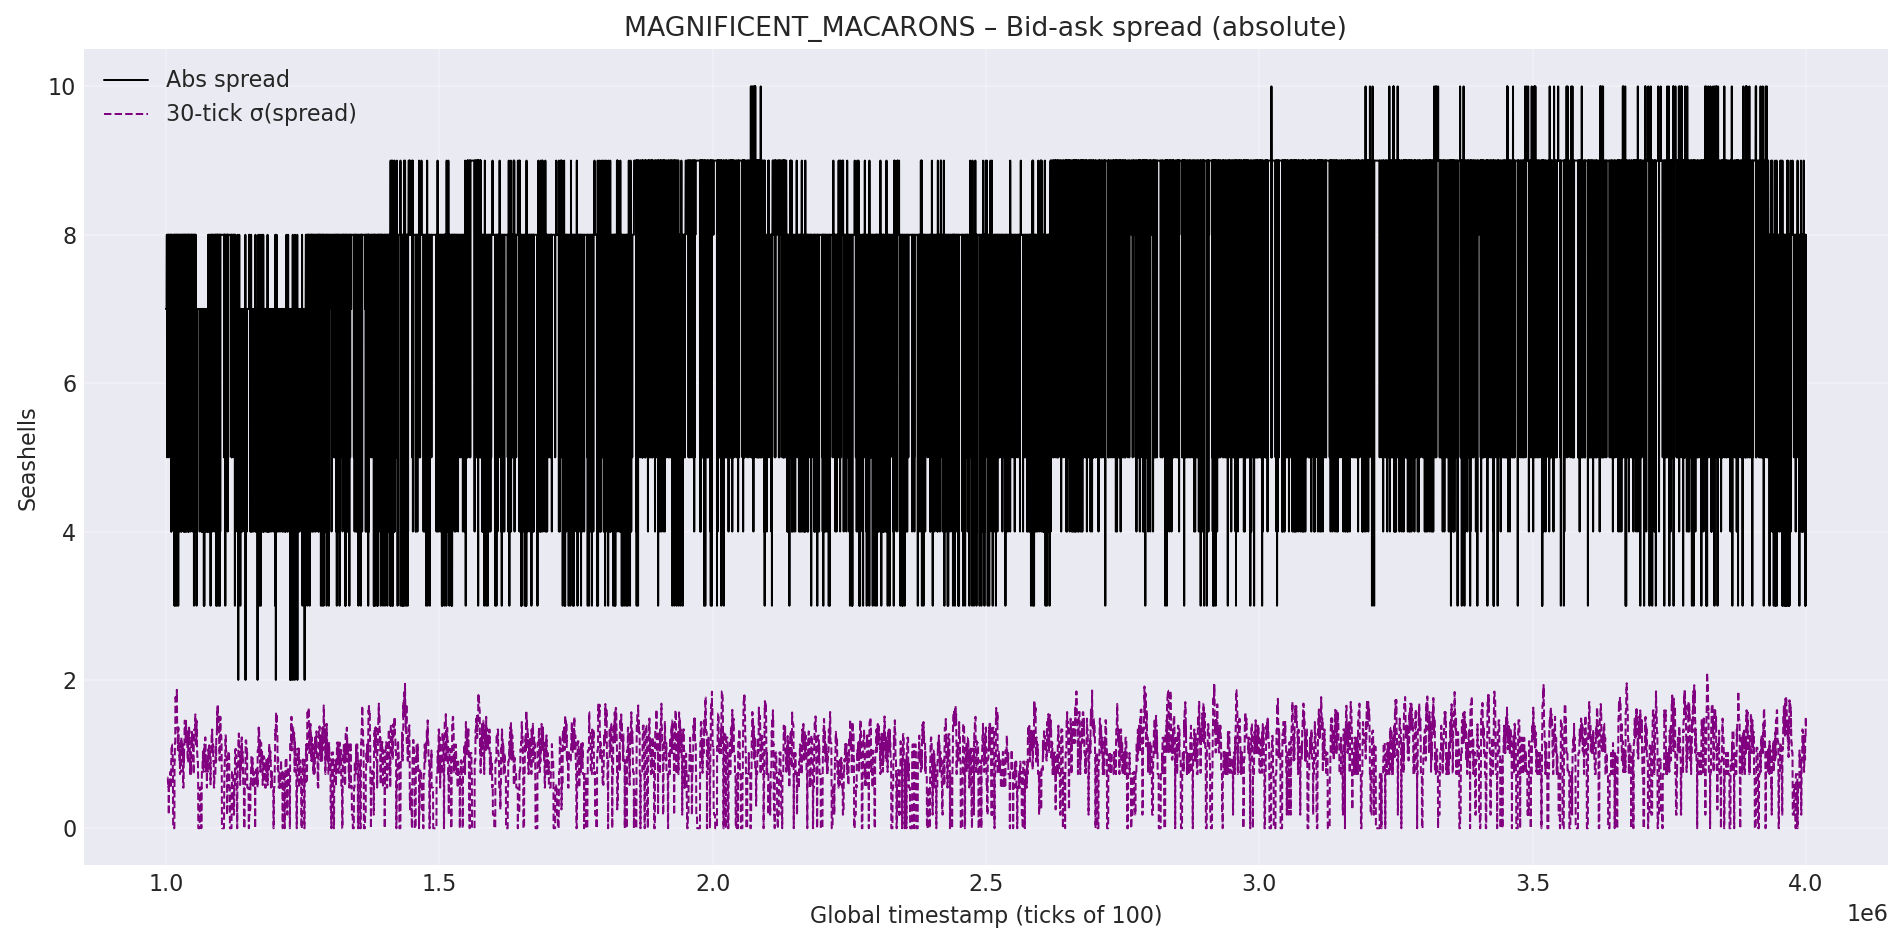

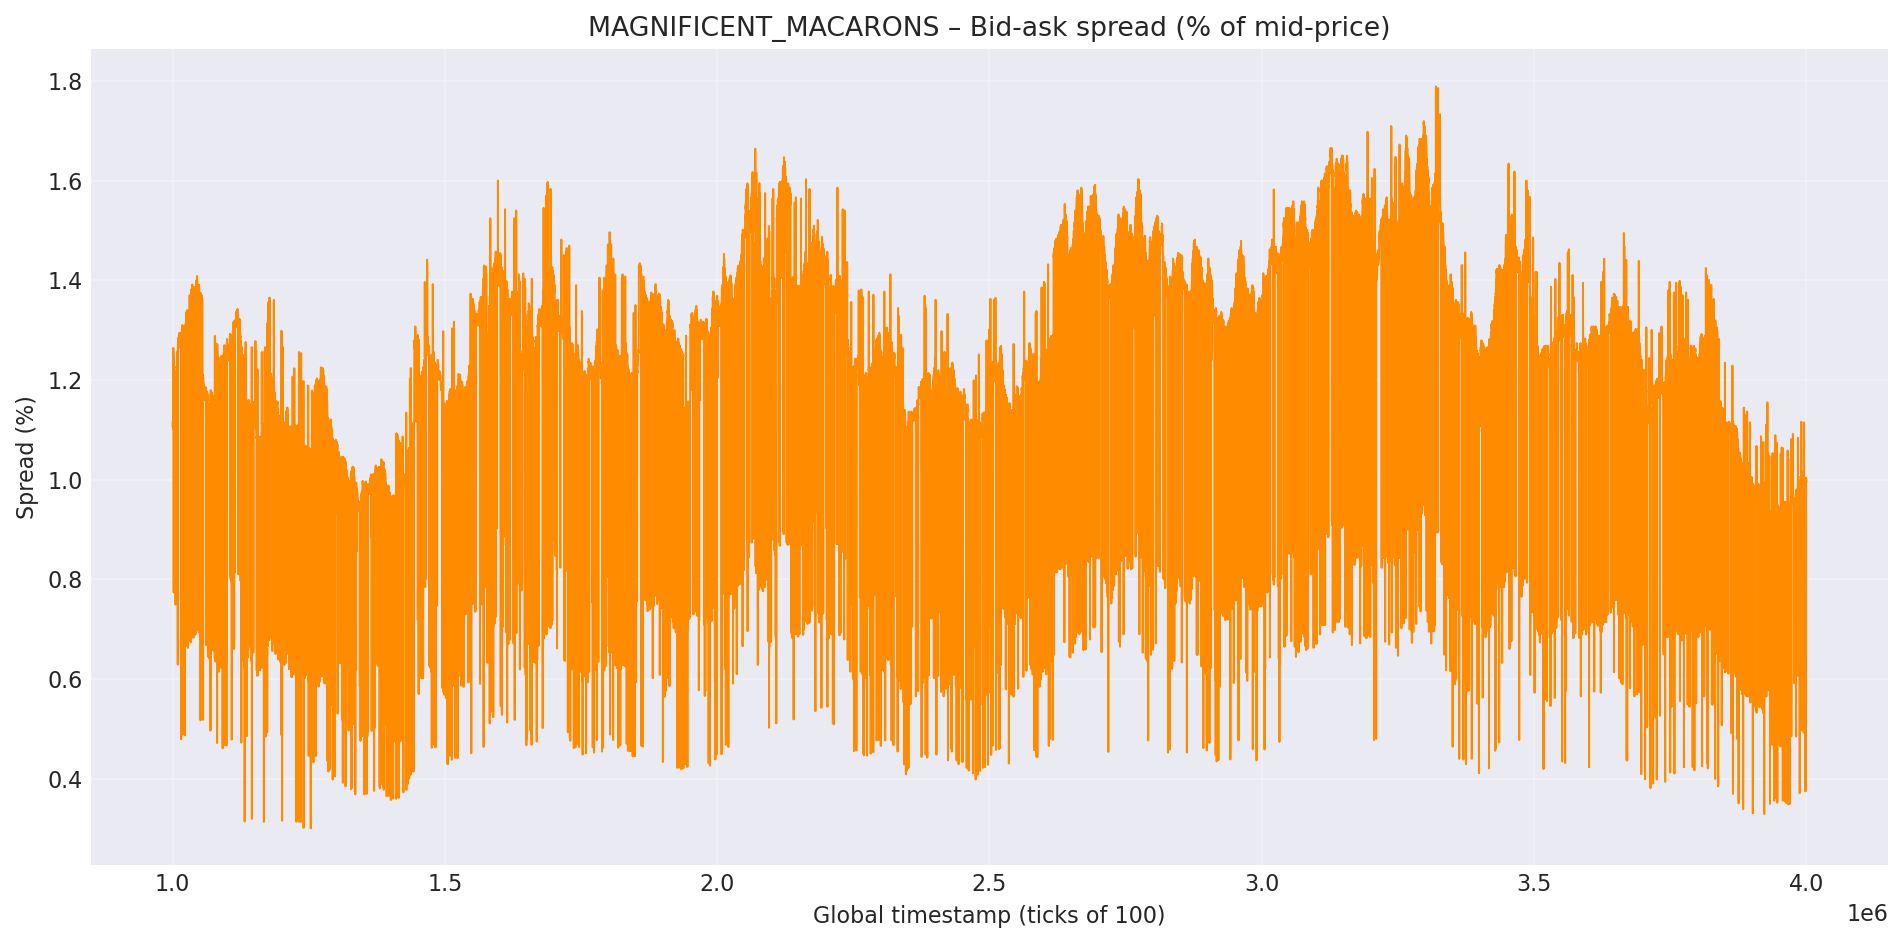

In [67]:
BOOK_CSV = "../data/round4/prices_combined_r4.csv"   # adjust to your path
SYMBOL   = "MAGNIFICENT_MACARONS"
TICKS_PER_DAY = 1_000_000

ob = pd.read_csv(BOOK_CSV, sep=";")
ob = ob[ob["product"] == SYMBOL].copy()

# ----- best bid / ask across first 3 levels
bid_cols = [f"bid_price_{i}" for i in (1,2,3)]
ask_cols = [f"ask_price_{i}" for i in (1,2,3)]
ob["best_bid"] = ob[bid_cols].max(axis=1, skipna=True)
ob["best_ask"] = ob[ask_cols].min(axis=1, skipna=True)

# mid‑price (use file’s if present)
ob["mid_price"] = (ob.get("mid_price")
                   .fillna((ob["best_bid"] + ob["best_ask"]) / 2))

# spreads
ob["spread_abs"] = ob["best_ask"] - ob["best_bid"]
ob["spread_pct"] = ob["spread_abs"] / ob["mid_price"]
ob["roll_std_abs"] = ob["spread_abs"].rolling(30).std()

# timeline
ob["gts"] = ob["day"]*TICKS_PER_DAY + ob["timestamp"]

# ---------- 1) price panel -------------------------------------------------
fig1, axp = plt.subplots(figsize=(12,6), dpi=160)
axp.plot(ob["gts"], ob["best_bid"], lw=1.0, c="forestgreen", label="Best bid")
axp.plot(ob["gts"], ob["best_ask"], lw=1.0, c="firebrick",   label="Best ask")
axp.plot(ob["gts"], ob["mid_price"], lw=0.8, c="navy",       label="Mid‑price")
axp.set_title(f"{SYMBOL} – Best bid / ask / mid")
axp.set_xlabel("Global timestamp (ticks of 100)")
axp.set_ylabel("Price (SeaShells)")
axp.legend(); axp.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ---------- 2) absolute spread --------------------------------------------
fig2, ax_abs = plt.subplots(figsize=(12,6), dpi=160)
ax_abs.plot(ob["gts"], ob["spread_abs"], lw=0.9, c="black", label="Abs spread")
ax_abs.plot(ob["gts"], ob["roll_std_abs"], lw=0.9, ls="--",
            c="purple", label="30‑tick σ(spread)")
ax_abs.set_title(f"{SYMBOL} – Bid‑ask spread (absolute)")
ax_abs.set_xlabel("Global timestamp (ticks of 100)")
ax_abs.set_ylabel("Seashells")
ax_abs.legend(); ax_abs.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ---------- 3) percentage spread ------------------------------------------
fig3, ax_pct = plt.subplots(figsize=(12,6), dpi=160)
ax_pct.plot(ob["gts"], ob["spread_pct"]*100, lw=0.9, c="darkorange")
ax_pct.set_title(f"{SYMBOL} – Bid‑ask spread (% of mid‑price)")
ax_pct.set_xlabel("Global timestamp (ticks of 100)")
ax_pct.set_ylabel("Spread (%)")
ax_pct.grid(alpha=.3)
plt.tight_layout(); plt.show()

In [68]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

ROLL = 30   # window length (ticks)

# 1) rolling Z‑score of abs spread
ob["roll_mean_abs"] = ob["spread_abs"].rolling(ROLL).mean()
ob["roll_std_abs"]  = ob["spread_abs"].rolling(ROLL).std()
ob["z_spread"]      = (ob["spread_abs"] - ob["roll_mean_abs"]) / ob["roll_std_abs"]

print("Rolling Z‑score column added as   ob['z_spread']")

# 2) Augmented Dickey‑Fuller on abs spread
adf_stat, pval, lags, nobs, crit, icbest = adfuller(ob["spread_abs"].dropna(),
                                                    autolag="AIC")
print("\nADF test on absolute spread")
print(f"  Test statistic : {adf_stat: .4f}")
print(f"  p‑value        : {pval: .4g}")
print(f"  # lags used    : {lags}")
print("  Critical values:")
for k, v in crit.items():
    print(f"     {k}%  : {v: .4f}")

# 3) Johansen cointegration between best bid & best ask
jb_res = coint_johansen(ob[["best_bid","best_ask"]].dropna(), det_order=0, k_ar_diff=1)
trace_stat = jb_res.lr1       # trace statistics
crit_vals  = jb_res.cvt       # critical values (90,95,99%)
print("\nJohansen cointegration (rank test) on [best_bid, best_ask]")
for i, ts in enumerate(trace_stat):
    crit90, crit95, crit99 = crit_vals[i]
    print(f"  r <= {i}  : trace = {ts: .4f} | crit (90,95,99%) = "
          f"{crit90: .4f}, {crit95: .4f}, {crit99: .4f}")


Rolling Z‑score column added as   ob['z_spread']

ADF test on absolute spread
  Test statistic : -6.7845
  p‑value        :  2.452e-09
  # lags used    : 49
  Critical values:
     1%%  : -3.4306
     5%%  : -2.8616
     10%%  : -2.5668

Johansen cointegration (rank test) on [best_bid, best_ask]
  r <= 0  : trace =  7091.8038 | crit (90,95,99%) =  13.4294,  15.4943,  19.9349
  r <= 1  : trace =  6.5375 | crit (90,95,99%) =  2.7055,  3.8415,  6.6349


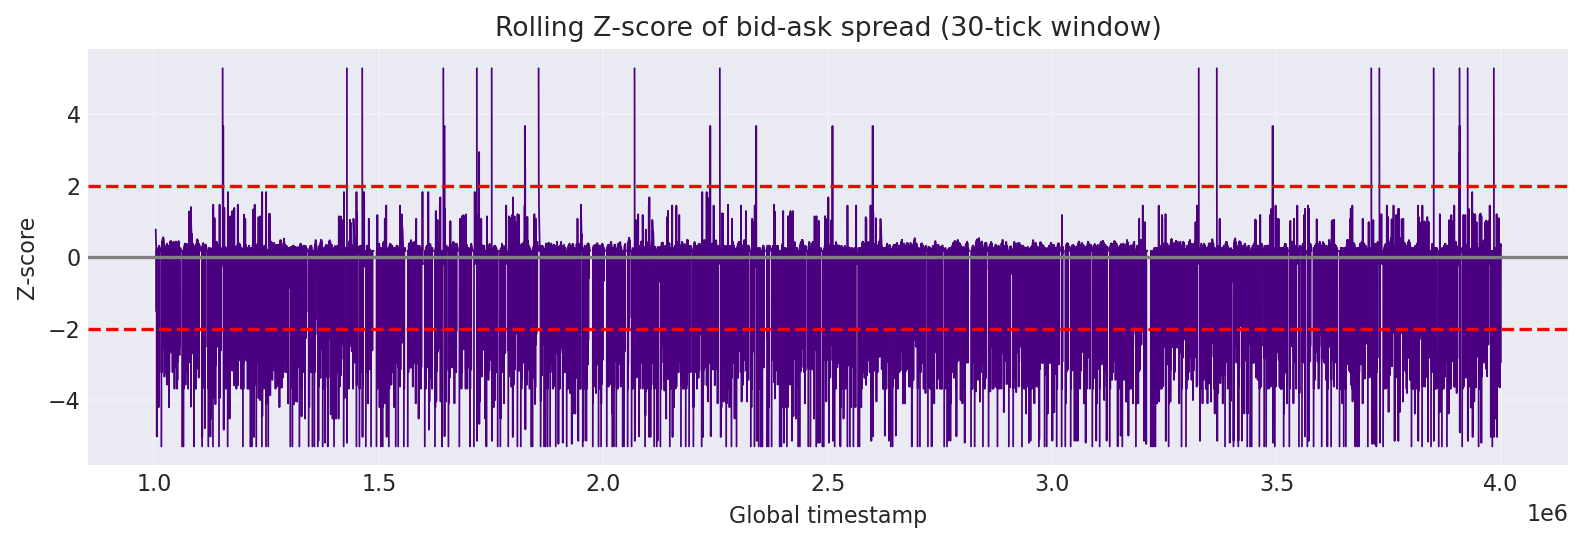

In [69]:
# %% Plot rolling Z‑score of spread  ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(10,3.5), dpi=160)
ax.plot(ob["gts"], ob["z_spread"], lw=0.8, color="indigo")
ax.axhline(0,color="grey"); ax.axhline(2,color="red",ls="--"); ax.axhline(-2,color="red",ls="--")
ax.set_title("Rolling Z‑score of bid‑ask spread (30‑tick window)")
ax.set_xlabel("Global timestamp"); ax.set_ylabel("Z‑score")
ax.grid(alpha=.3); plt.tight_layout(); plt.show()


## Seeing for more patterns, renaming dataframes cause ooga booga

In [70]:
# %% 0 ─────────── Additional imports ─────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from arch import arch_model
from sklearn.mixture import GaussianMixture


In [71]:

BOOK_CSV = "../data/round4/prices_combined_r4.csv"
TRADES_CSV = "../data/round4/trades_combined_r4.csv"
OBS_CSV    = "../data/round4/observations_combined_r4.csv"
SYMBOL = "MAGNIFICENT_MACARONS"
TICKS_PER_DAY = 1_000_000

# order-book
ob = pd.read_csv(BOOK_CSV, sep=";")
ob = ob[ob["product"] == SYMBOL].copy()
# trades+obs merged
trades = pd.read_csv(TRADES_CSV, sep=";")
obs    = pd.read_csv(OBS_CSV,    sep=";")
trades["symbol"]=trades["symbol"].str.strip()
mm = trades.query("symbol==@SYMBOL").copy()
obs_cols=["bidPrice","askPrice","transportFees","exportTariff","importTariff","sugarPrice","sunlightIndex"]
obs[obs_cols]=obs[obs_cols].apply(pd.to_numeric,errors="coerce")
merged = mm.merge(obs,on=["day","timestamp"],how="left")
merged["midPrice"] = (merged["bidPrice"]+merged["askPrice"])/2
# global timestamps
ob["gts"]     = ob["day"]*TICKS_PER_DAY + ob["timestamp"]
merged["gts"] = merged["day"]*TICKS_PER_DAY + merged["timestamp"]


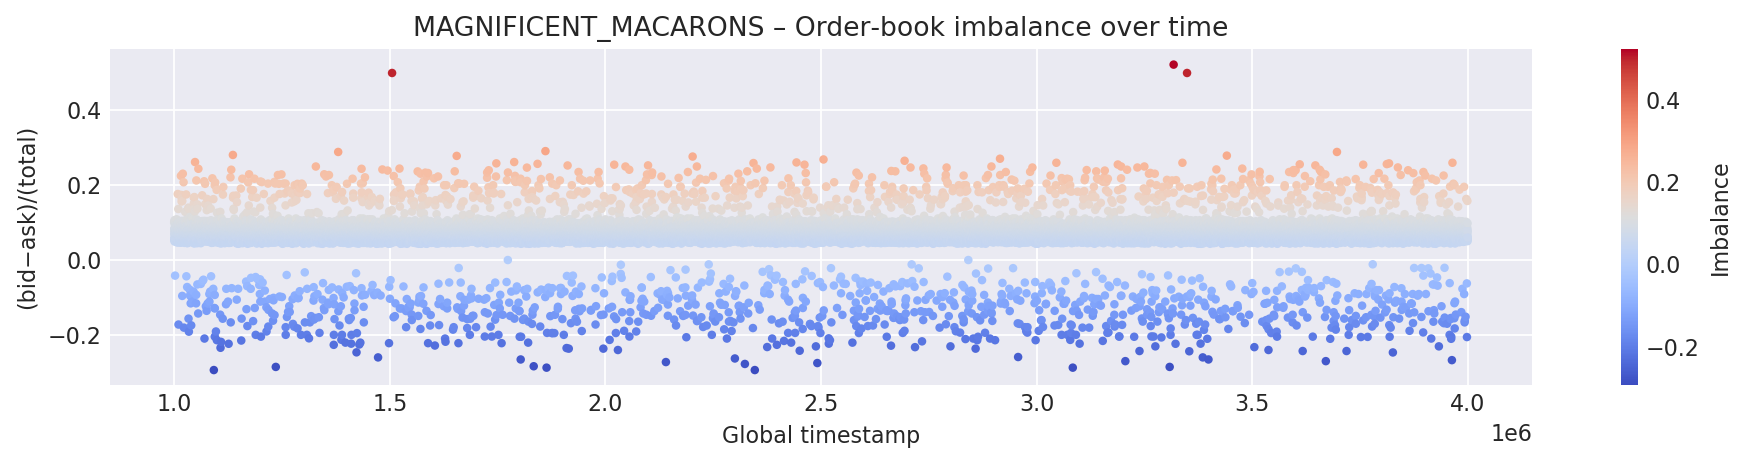

In [72]:
# %% 2 ─────── Intra‑day depth & imbalance profile ──────────────────────────
# total depth at levels 1‑3
bid_vols = [f"bid_volume_{i}" for i in (1,2,3)]
ask_vols = [f"ask_volume_{i}" for i in (1,2,3)]
ob["depth_bid"] = ob[bid_vols].sum(axis=1)
ob["depth_ask"] = ob[ask_vols].sum(axis=1)
# imbalance
ob["imbalance"] = (ob["depth_bid"] - ob["depth_ask"]) / (ob["depth_bid"] + ob["depth_ask"])
# heatmap of imbalance vs time
plt.figure(figsize=(12,3), dpi=160)
plt.scatter(ob["gts"], ob["imbalance"], c=ob["imbalance"], cmap="coolwarm", s=8)
plt.colorbar(label="Imbalance")
plt.title(f"{SYMBOL} – Order‑book imbalance over time")
plt.xlabel("Global timestamp"); plt.ylabel("(bid−ask)/(total)")
plt.tight_layout(); plt.show()


In [75]:

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

# 1) Recompute best_bid, best_ask & absolute spread on ob
bid_cols = [f"bid_price_{i}" for i in (1,2,3)]
ask_cols = [f"ask_price_{i}" for i in (1,2,3)]

ob["best_bid"]   = ob[bid_cols].max(axis=1, skipna=True)
ob["best_ask"]   = ob[ask_cols].min(axis=1, skipna=True)
ob["spread_abs"] = ob["best_ask"] - ob["best_bid"]

# if you also want to ensure imbalance is there (from cell 2), uncomment:
# vol_bid_cols = [f"bid_volume_{i}" for i in (1,2,3)]
# vol_ask_cols = [f"ask_volume_{i}" for i in (1,2,3)]
# ob["depth_bid"]  = ob[vol_bid_cols].sum(axis=1)
# ob["depth_ask"]  = ob[vol_ask_cols].sum(axis=1)
# ob["imbalance"]  = (ob["depth_bid"] - ob["depth_ask"]) / (ob["depth_bid"] + ob["depth_ask"])

# 2) Flag snapshots where a trade happened next tick
obs_events = merged[["gts"]].copy()
obs_events["trade_next"] = 1

# 3) Merge and fill
df_flow = (
    ob[["gts","spread_abs","imbalance"]]
    .merge(obs_events, on="gts", how="left")
    .fillna(0)
)

# 4) Rolling Z‑score of the spread (30‑tick window)
df_flow["z_spread"] = (
    (df_flow["spread_abs"] - df_flow["spread_abs"].rolling(30).mean())
    / df_flow["spread_abs"].rolling(30).std()
)

# 5) Logistic regression: does wide spread or imbalance predict immediate trade?
df_flow = df_flow.dropna(subset=["z_spread","imbalance","trade_next"])
X = sm.add_constant(df_flow[["z_spread","imbalance"]])
y = df_flow["trade_next"]

model = Logit(y, X).fit(disp=False)
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:             trade_next   No. Observations:                27672
Model:                          Logit   Df Residuals:                    27669
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:                 0.06911
Time:                        03:10:30   Log-Likelihood:                -4053.6
converged:                       True   LL-Null:                       -4354.5
Covariance Type:            nonrobust   LLR p-value:                2.049e-131
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4098      0.044    -77.129      0.000      -3.496      -3.323
z_spread      -0.4998      0.019    -26.400      0.000      -0.537      -0.463
imbalance     -0.4873      0.383     -1.271      0.2

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Apr, 2025
Time:                     03:13:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.38737
Nobs:                     29998.0    HQIC:                   2.38624
Log likelihood:          -120908.    FPE:                    10.8667
AIC:                      2.38571    Det(Omega_mle):         10.8646
--------------------------------------------------------------------
Results for equation best_bid
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.005875         0.015248            0.385           0.700
L1.best_bid        -0.283990         0.010724          -26.481           0.000
L1.best_ask         0.228595         0.010692           21.381   

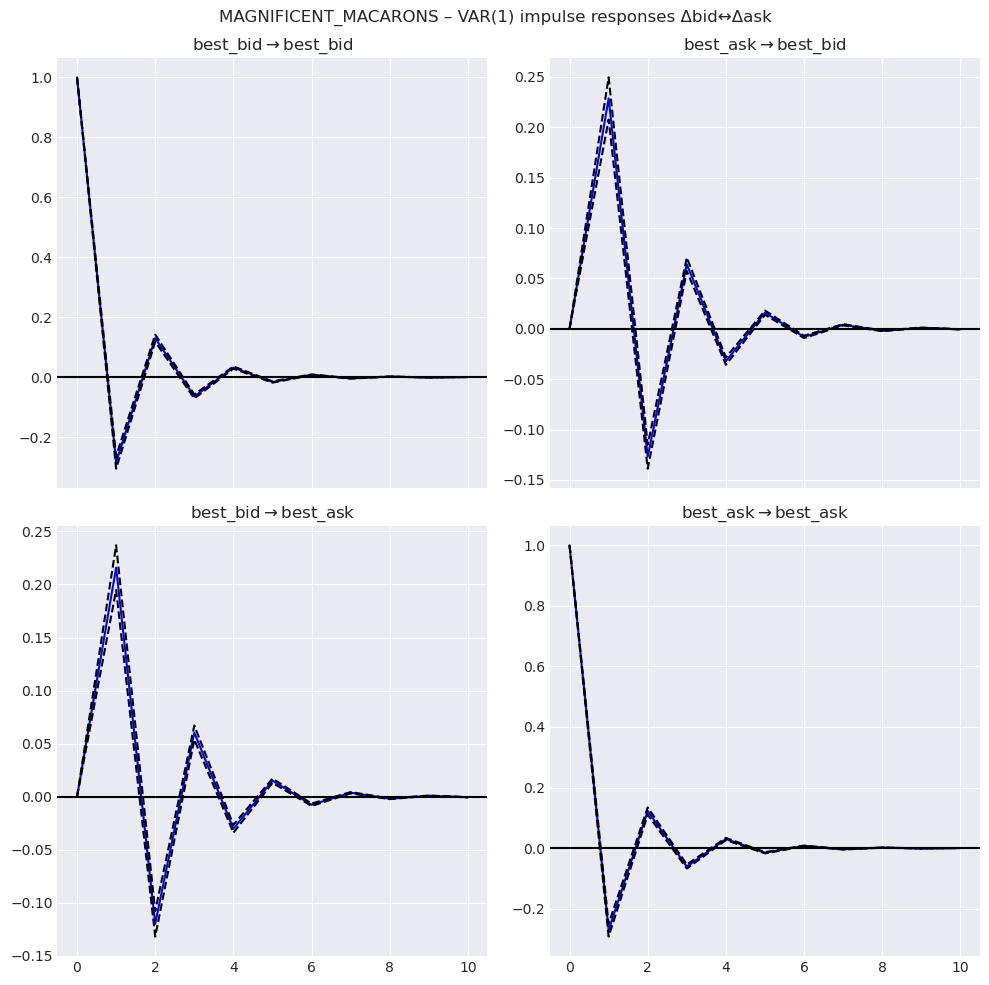

In [78]:

from statsmodels.tsa.vector_ar.var_model import VAR

# 1) Difference the series to get Δbest_bid and Δbest_ask
df_var = ob[["best_bid", "best_ask"]].diff().dropna().reset_index(drop=True)

# 2) Fit a VAR(1)
model_var = VAR(df_var)
res_var   = model_var.fit(1)

# 3) Summary and impulse responses
print(res_var.summary())

ir = res_var.irf(10)
fig = ir.plot(orth=False)
plt.suptitle(f"{SYMBOL} – VAR(1) impulse responses Δbid↔Δask")
plt.tight_layout(); plt.show()


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             spread_abs   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -47679.4
Distribution:                  Normal   AIC:                           95366.8
Method:            Maximum Likelihood   BIC:                           95400.1
                                        No. Observations:                30000
Date:                Fri, Apr 18 2025   Df Residuals:                    29999
Time:                        03:13:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.1900  1.639e-02    499.681      0.000 [  8.158,  8.22

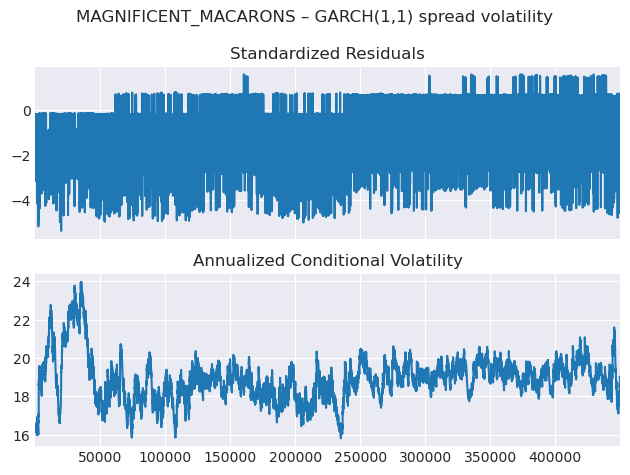

In [79]:
# %% 5 ───────── GARCH(1,1) on absolute spread volatility ───────────────────
am = arch_model(ob["spread_abs"].dropna(), vol="Garch", p=1, q=1, dist="normal")
res_am = am.fit(disp="off")
print(res_am.summary())
res_am.plot(annualize="D")
plt.suptitle(f"{SYMBOL} – GARCH(1,1) spread volatility")
plt.tight_layout(); plt.show()


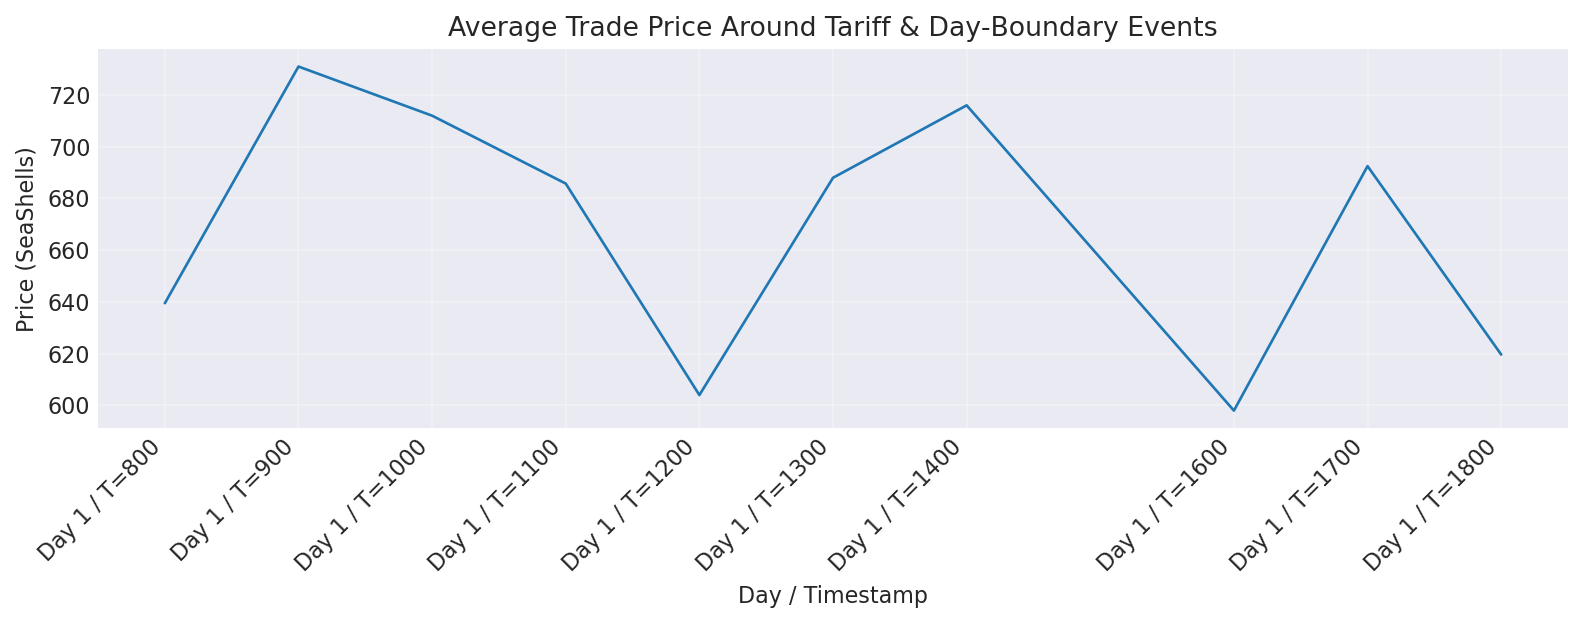

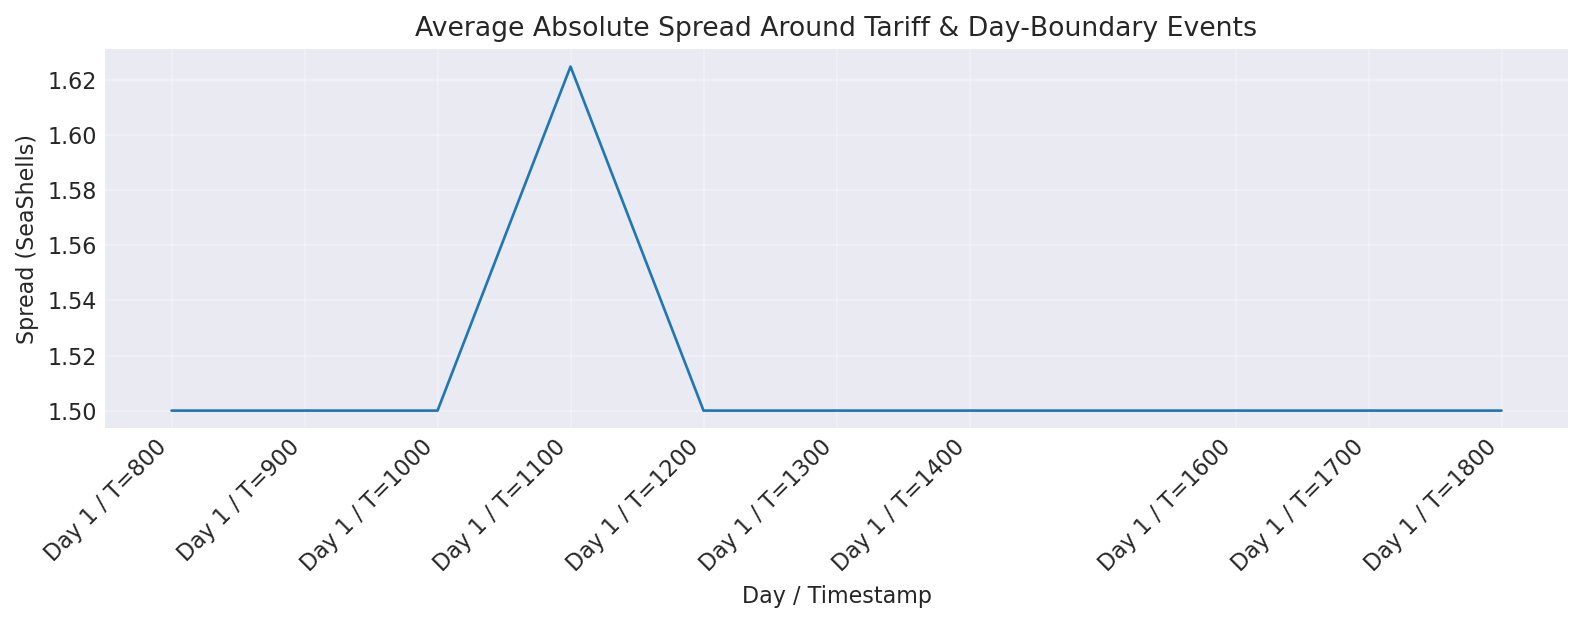

In [88]:
# %% 6 ─── Event study with day‐boundaries injected & n=10 Day/T labels ────
import numpy as np
import matplotlib.pyplot as plt

# 0) recompute spread_abs
merged["spread_abs"] = merged["askPrice"] - merged["bidPrice"]

# 1) find real tariff flips
obs["imp_diff"] = obs["importTariff"].diff().abs().fillna(0)
obs["exp_diff"] = obs["exportTariff"].diff().abs().fillna(0)
flips = obs[(obs["imp_diff"]>0) | (obs["exp_diff"]>0)][["day","timestamp"]]

# 1b) inject day‐boundary events for day 2 & 3 at t=0
day_boundaries = pd.DataFrame({
    "day": [2, 3],
    "timestamp": [0, 0]
})
flips = pd.concat([flips, day_boundaries], ignore_index=True)

# 2) build ±5‐tick windows
window = 5 * 100
studies = []
for _, r in flips.iterrows():
    flip_gts = int(r["day"]*TICKS_PER_DAY + r["timestamp"])
    mask = merged["gts"].between(flip_gts - window, flip_gts + window)
    temp = merged.loc[mask, ["gts","price","spread_abs"]].copy()
    temp["align"] = temp["gts"] - flip_gts
    studies.append(temp.set_index("align")[["price","spread_abs"]])

# 3) average
avg = pd.concat(studies).groupby(level=0).mean()

# 4) build tick positions & labels (n=10)
n_ticks = 10
idxs = np.linspace(0, len(avg)-1, n_ticks, dtype=int)
labels = []
for i in idxs:
    # take the median event to label against
    # here we use the first injected event that covers all days
    # you could also average the days, but we'll just show day from flips[0]
    # now that flips contains 1,2,3 you'll see all three
    g = int(flips.iloc[0].day)*TICKS_PER_DAY + int(flips.iloc[0].timestamp) + avg.index[i]
    d, t = g // TICKS_PER_DAY, g % TICKS_PER_DAY
    labels.append(f"Day {d} / T={t}")

# 5a) plot average price
fig, ax = plt.subplots(figsize=(10,4), dpi=160)
ax.plot(avg["price"], lw=1.2)
ax.set_xticks(avg.index[idxs])
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Average Trade Price Around Tariff & Day‑Boundary Events")
ax.set_xlabel("Day / Timestamp")
ax.set_ylabel("Price (SeaShells)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5b) plot average spread
fig, ax = plt.subplots(figsize=(10,4), dpi=160)
ax.plot(avg["spread_abs"], lw=1.2)
ax.set_xticks(avg.index[idxs])
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Average Absolute Spread Around Tariff & Day‑Boundary Events")
ax.set_xlabel("Day / Timestamp")
ax.set_ylabel("Spread (SeaShells)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


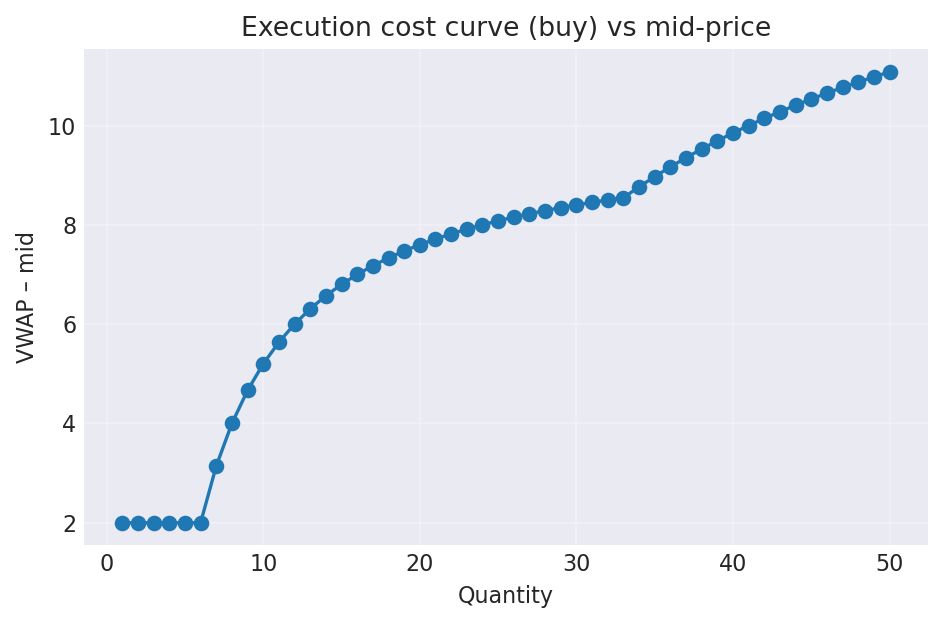

In [89]:
# %% 7 ───────── Execution‑cost curve (virtual taker) ────────────────────────
# assume single snapshot, example at mid‑round
snap = ob.iloc[100]  # choose a representative tick
# build ask book
asks = []
for i in (1,2,3):
    pr = snap[f"ask_price_{i}"]; vol = snap[f"ask_volume_{i}"]
    if not np.isnan(pr): asks.extend([pr]*int(vol))
# cumulative cost for buy sizes 1…min(50,len(asks))
max_q = min(50, len(asks))
costs = []
mid = snap["mid_price"]
for q in range(1, max_q+1):
    cost = np.mean(asks[:q])
    costs.append((q, cost-mid))
df_cost = pd.DataFrame(costs, columns=["qty","cost_minus_mid"])
plt.figure(figsize=(6,4), dpi=160)
plt.plot(df_cost["qty"], df_cost["cost_minus_mid"], marker="o")
plt.title("Execution cost curve (buy) vs mid‑price")
plt.xlabel("Quantity"); plt.ylabel("VWAP – mid"); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()
